# Quick perusal of the post-processed monte carlo output data

## Setup

In [1]:
# Set local path
import sys
sys.path.append('random-forest')
sys.path.append('utils')


# Imports
import pandas as pd
import numpy as np
# import scipy.io as spio
from os.path import join
from math import ceil
from utils.mat_tools import matfile_struct_to_dict as mat2dict
from utils.mat_tools import extrapVentRadius
import pprint
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
# from sklearn.preprocessing import minmax_scale
import rf_train as rft
# from sklearn.neighbors import NearestNeighbors
# from scipy.spatial import KDTree
import seaborn as sns
import matplotlib.pyplot as plt

/Users/crrowell/code/research-projects/katla/katlaPlumePhysicsEmulator/random-forest/rf_train.py:404: SyntaxWarning: invalid escape sequence '\d'
  axes[0,zi].set_title(f'$\displaystyle Z_{{e,MAX}} = {ze}$ m')


In [2]:
# ---- Directories and files ----
data_dir = 'data/'

monte_carlo_fixed_vars_file = join(data_dir, 'fixed_MC_vars.mat')  # Simulation, fixed input parameters
monte_carlo_rand_vars_file  = join(data_dir, 'rand_MC_vars.parquet') # Simulation, randomized input parameters
 # I/O data table for main parameters of interest, water depths up to 360 m
monte_carlo_data_file       = join(data_dir, 'KatlaHydro_v8_noLd_2024-06-30_N20000.parquet') 
 # data table for main parameters, scaled/non-dimensionalized
monte_carlo_scaled_file     = join(data_dir, 'KatlaHydro_v8_noLd_2024-06-30_N20000_scaled.parquet')
# Smaller test data set with water depths up to 500 m for testing
test_data_file              = join(data_dir, 'KatlaHydro_v8_noLd_2024-06-22_N10000.parquet') 
# Scaled test data set, mostly handy for validation and plotting
scaled_test_data_file       = join(data_dir, 'KatlaHydro_v8_noLd_2024-06-22_N10000_scaled.parquet') 

# ---- DATA PARAMS ----
search_radius = 0.05

# ---- RF PARAMS ----
# Split siize
train_size = 0.2 # Small set for now
test_size  = 0.1

n_estimators = 100
max_depth    = 20
bootstrap    = True
oob_score    = True
n_jobs       = 2
min_samples_split = 5
min_samples_leaf = 4
verbose = 1

# Grid search params
param_grid = {'n_estimators' : [100],
              'max_depth' :  [10, 20, 30,],
              # 'min_samples_split' : [5],
              'min_samples_leaf' : [2,4,8,16],
             }

# ----- Some handy switches----
train_all_vars = False

## Data exploration and QC

In [3]:
# Load up data
monte_carlo_fixed_vars = mat2dict(monte_carlo_fixed_vars_file,'fixedVars')
monte_carlo_rand_vars  = pd.read_parquet(monte_carlo_rand_vars_file)
mc_df                  = pd.read_parquet(monte_carlo_data_file)
mc_df_scaled           = pd.read_parquet(monte_carlo_scaled_file)
mc_df_test             = pd.read_parquet(test_data_file)
mc_df_test_scaled      = pd.read_parquet(scaled_test_data_file)

In [4]:
# Check data overview
print('\n---> I/O data table:')
mc_df.info()
# print(mc_df.describe())

print('\n---> Scaled data table:')
mc_df_scaled.info()

print('\n---> TEST data table:')
mc_df_test.info()

print('\n---> SCALED TEST data table:')
mc_df_test_scaled.info()


---> I/O data table:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19999 entries, 0 to 19998
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   T               19999 non-null  float64
 1   Ze              19999 non-null  float64
 2   n_0             19999 non-null  float64
 3   n_ec            19999 non-null  float64
 4   Q               19999 non-null  float64
 5   conduit_radius  19999 non-null  float64
 6   D               19999 non-null  float64
 7   clps_regime     19999 non-null  float64
 8   hm              19999 non-null  float64
 9   qs0             19999 non-null  float64
 10  qsC             19999 non-null  float64
 11  rC              19999 non-null  float64
 12  qw0             19999 non-null  float64
 13  qwC             19999 non-null  float64
dtypes: float64(14)
memory usage: 2.1 MB

---> Scaled data table:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19999 entries, 0 to 19998
Data co

In [5]:
# ----- Some data prep and labeling -------

# Fill nans in the test set
mc_df_test['hm'] = mc_df_test['hm'].fillna(0.)

# Will use the log for training and testing
mc_df['logQ'] =  np.log10(mc_df['Q'])
mc_df_test['logQ'] = np.log10(mc_df_test['Q'])

# Build some labels for later use
input_vars = ['Ze','logQ'] #,'n_total','a_over_Rv','T'] # monte_carlo_rand_vars['Variable']
scaled_input_vars = ['Ze_over_Rv','logQ']

output_vars = ['hm','rC','qw0','qwC','qs0','qsC']
scaled_output_vars = ['hm_over_Q14','rC_over_Rv','qw0_over_Q','qwC_over_Q','qs0_over_Q','qsC_over_Q']




In [6]:
# Set of SCALED 2D coordinate points and averaged point clouds for comparison
use_training_set = False

Ze_range_train = (0, 360)  # Water depth range in training set
Ze_range = (0, 500)  # Water depth range in test set
Q_range  = (6, 8)    # LogQ range in training set

# Re-scaled data points between 0 and 1 for point queries - here we can choose EITHER the training or test set
# --> TRAINING SET
if use_training_set:
    
    ze_scaled = rft.scale_to_range(mc_df['Ze'], Ze_range )
    logQ_scaled = rft.scale_to_range(mc_df_scaled['logQ'], Q_range)
    coordinate_points = np.column_stack((ze_scaled,logQ_scaled))
    data_points = mc_df[output_vars]

# --> TEST SET
else:

    ze_scaled = rft.scale_to_range(mc_df_test['Ze'], Ze_range )
    logQ_scaled = rft.scale_to_range(mc_df_test_scaled['logQ'], Q_range)
    coordinate_points = np.column_stack((ze_scaled,logQ_scaled))
    data_points = mc_df_test[output_vars]

# Get a comparison error estimate for test set relative to smoothed test set
averaged_training_data = rft.get_averaged_point_cloud(mc_df[input_vars+output_vars],
                                                 coordinate_columns=['Ze','logQ'],
                                                 scale_ranges = {'Ze':Ze_range_train, 'logQ': Q_range},
                                                 radius = search_radius)

averaged_test_data = rft.get_averaged_point_cloud(mc_df_test[input_vars+output_vars],
                                                 coordinate_columns=['Ze','logQ'],
                                                 scale_ranges = {'Ze':Ze_range, 'logQ': Q_range},
                                                 radius = search_radius)

averaged_scaled_test_data = rft.apply_physical_data_scaling(averaged_test_data, mc_df_test['Q'])


# rft.get_averaged_point_cloud(mc_df_test_scaled[['Ze_over_Rv','logQ']+scaled_output_vars],
#                                                  coordinate_columns=['Ze_over_Rv','logQ'],
#                                                  scale_ranges = {'Ze_over_Rv':(0.,mc_df_scaled['Ze_over_Rv'].max()),
#                                                                  'logQ': Q_range},
#                                                  radius = search_radius)


In [7]:
# %matplotlib widget 
# from mpl_toolkits.mplot3d import Axes3D 
# fig = plt.figure()
# ax = Axes3D(fig) 

# fig = plt.figure()
# ax = fig.add_subplot(projection='3d')
# # ax.scatter(mc_df_scaled['Ze_over_Rv'],averaged_training_data['hm'])
# ax.scatter(mc_df_test_scaled['Ze_over_Rv'],mc_df_test['logQ'],mc_df_test['hm'],s=2,alpha=0.5)
# ax.scatter(mc_df_scaled['Ze_over_Rv'],mc_df['logQ'],averaged_training_data['hm'],s=2,alpha=0.5)

In [8]:
# plt.scatter(mc_df_test_scaled['Ze_over_Rv'],mc_df_test_scaled['hm_over_Q14'],s=2,alpha=0.5)
# plt.scatter(mc_df_test_scaled['Ze_over_Rv'],averaged_scaled_test_data['hm_over_Q14'],s=2,alpha=0.5)


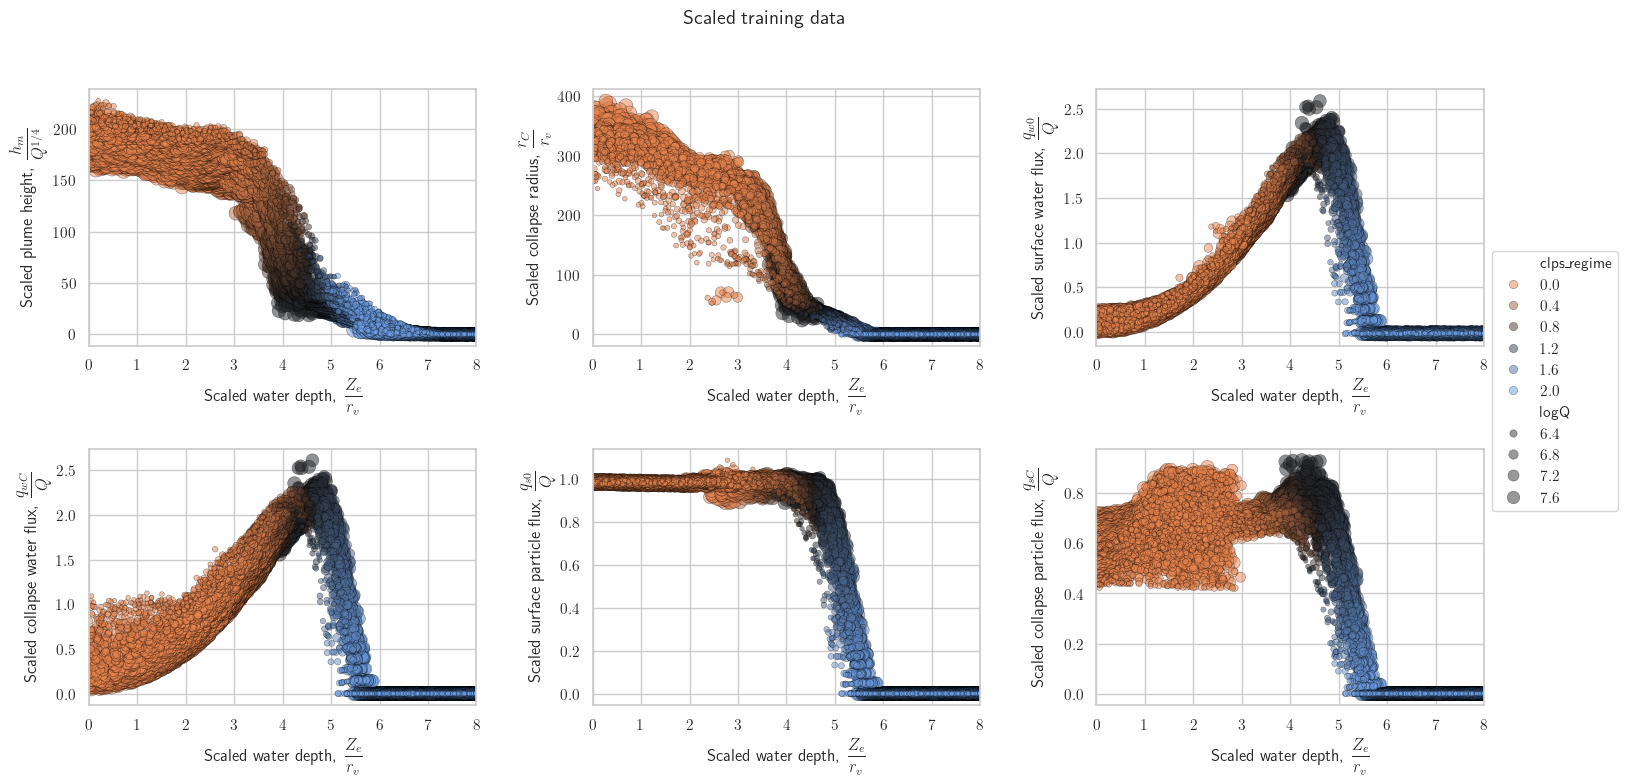

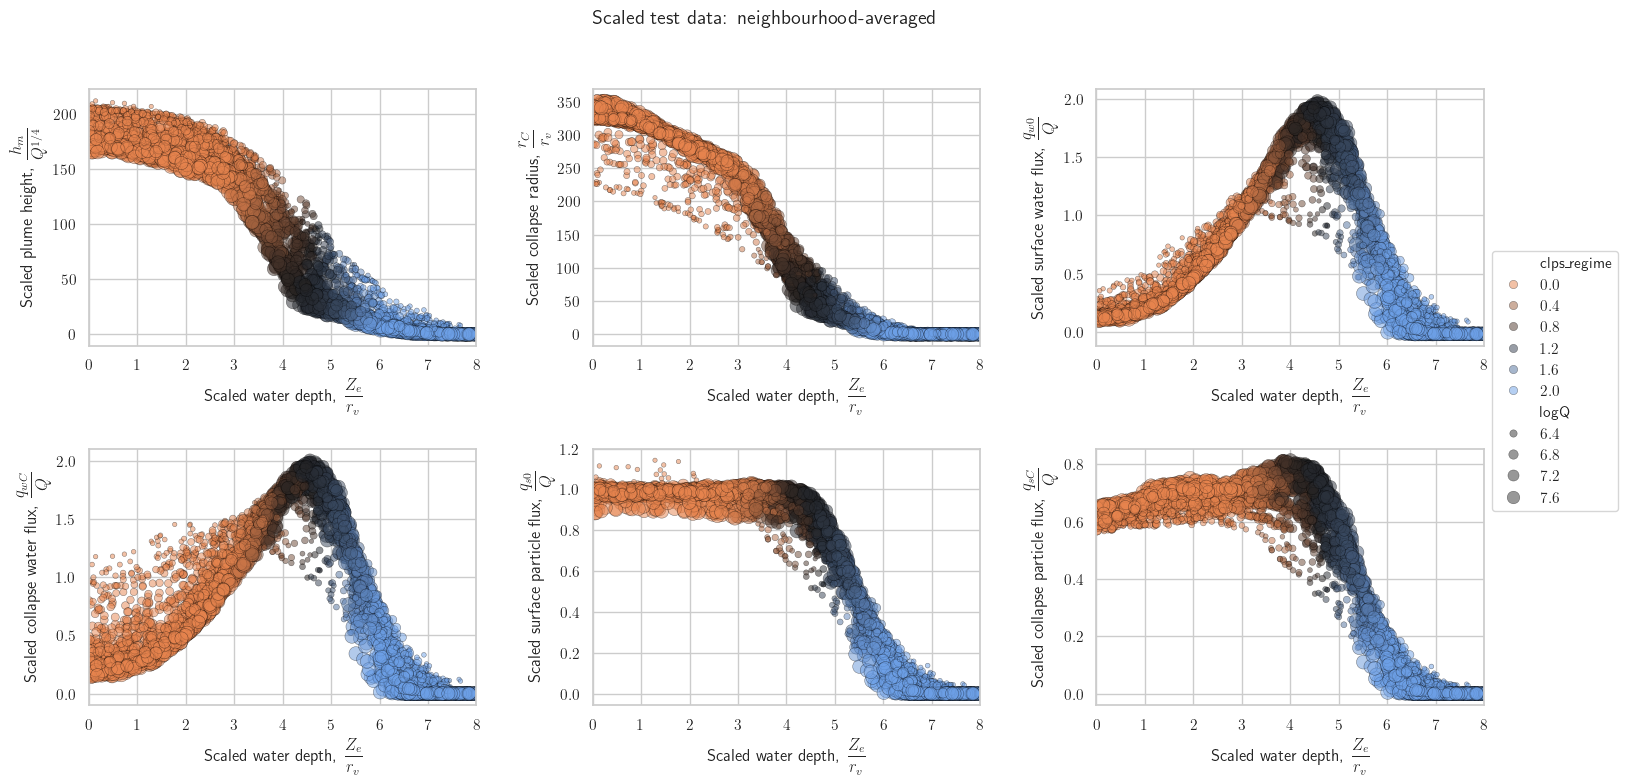

In [9]:
# Plot the scaled data set to better highlight physical relationships with water depth, Ze
%matplotlib inline
plt.rcParams['text.usetex'] = True



# ---- Make a few descriptive plots of the training dataset ----
rft.single_var_panels_scatter(mc_df_scaled.sort_values('logQ',ascending=False),
                           x_var = 'Ze_over_Rv',
                           y_vars = scaled_output_vars,
                           hue_var = 'clps_regime',
                           size_var = 'logQ',
                           title = 'Scaled training data',
                          )

rft.single_var_panels_scatter(pd.concat(
    [averaged_scaled_test_data,mc_df_test_scaled[scaled_input_vars+['clps_regime']]],axis=1),
                              # .sort_values('logQ',ascending=False),
                           x_var = 'Ze_over_Rv',
                           y_vars = scaled_output_vars,
                           hue_var = 'clps_regime',
                           size_var = 'logQ',
                           title = 'Scaled test data: neighbourhood-averaged',
                          )

## Build Random Forest using all available input variables to verify feature importance

In [10]:
# ---- Create feature inputs for random forest ----
# We will train on the UNscaled data set, since we want to random forest to learn the relationships

# Get logQ (log10 of mass flux) and n_total (total water vapor mass fraction) from the scaled data set

if train_all_vars:
    # Setup input/output variables - the last three are tacked on for now but unlikely to be very important
    X_train = pd.concat([mc_df_scaled['logQ'], mc_df['Ze'], mc_df_scaled[['n_total','a_over_Rv']], mc_df[['T','D']]], axis=1)
    Y_train = mc_df[output_vars]
    
    # For test data, we don't have the pre-built scaled data so need to quickly build a couple fields
    logQ_test         = np.log10(mc_df_test['Q'])
    n_total_test      = mc_df_test['n_0'] + mc_df_test['n_ec']
    a_over_Rv         = mc_df_test['conduit_radius'] / extrapVentRadius(mc_df_test['Q']) # Normally randomized vent radius scaled to a standard vent radius
    logQ_test.name, n_total_test.name, a_over_Rv.name    = 'logQ', 'a_over_Rv', 'n_total'
    
    # Build the test data frames
    X_test = pd.concat([logQ_test, mc_df_test['Ze'], n_total_test, a_over_Rv, mc_df_test[['T','D']]],axis=1)
    Y_test = mc_df_test[output_vars]
    
    # ---- Build classifier and train initial random forest ----
    regressor_rf = RandomForestRegressor(n_estimators=n_estimators, 
                                         max_depth=max_depth,
                                         min_samples_leaf=min_samples_leaf,
                                         bootstrap=bootstrap, 
                                         oob_score=oob_score,
                                         n_jobs=n_jobs,
                                         min_samples_split=min_samples_split,
                                         random_state=0,
                                         verbose=verbose)
    # Get scores and initial predictions
    regressor_rf.oob_score_
    
    # making the feature importances plot
    feature_imp = pd.Series(regressor_rf.feature_importances_, 
                            index=X_train.columns).sort_values(ascending=False)
    sns.barplot(x=feature_imp, y=feature_imp.index)
    plt.xlabel('Feature Importance Score', fontsize=12)
    plt.ylabel('Features', fontsize=12)
    plt.title("Visualizing Feature Importances", fontsize=15)

Not too surprisingly, only Ze and logQ register as important, the other variables are largely producing minor noise in this context

In [11]:
# ---- Build classifier and train initial random forest ----





regressor_rf = RandomForestRegressor(n_estimators=n_estimators, 
                                     max_depth=max_depth,
                                     min_samples_leaf=min_samples_leaf,
                                     bootstrap=bootstrap, 
                                     oob_score=oob_score,
                                     n_jobs=n_jobs,
                                     min_samples_split=min_samples_split,
                                     random_state=0,
                                     verbose=verbose)



In [12]:
# ---- CHOOSE training, validation, test data ------

# TRAINING
X_train = mc_df[['Ze','logQ']]
# Y_train = mc_df[output_vars] # To train on the raw, noisier data
Y_train = averaged_training_data # Targeting smoother results


# TEST
X_test = mc_df_test[['Ze','logQ']] #pd.concat([logQ_test, mc_df_test['Ze']],axis=1)
Y_test = averaged_test_data

regressor_rf.fit(X_train,Y_train)

# Get scores and initial predictions
regressor_rf.oob_score_
predictions = regressor_rf.predict(X_test)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    1.4s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    2.9s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.1s finished


In [28]:
# Put together test output and predicted output for easy plotting, in both scaled and unscaled formats

df_predict = pd.DataFrame(data=predictions, columns=output_vars)
df_test_predict = pd.concat([Y_test, df_predict.rename(columns={col:col+'_pred' for col in df_predict.columns})], axis=1)

# Get scaled prediction set for clear plots
# For test data, we don't have the pre-built scaled data so need to quickly build a couple fields
df_predict_scaled = rft.apply_physical_data_scaling(df_predict, Q_vec = mc_df_test['Q'])
df_predict_scaled[['Ze_over_Rv','logQ']] = mc_df_test_scaled[['Ze_over_Rv','logQ']]


# Scale random forest predictions and put them into the data frame
# # -> Plume height
# df_predict_scaled = df_predict_scaled.assign(hm_over_Q14=df_predict['hm'].div(mc_df_test['Q']**(1/4),axis=0))
# # -> Collapse radius
# df_predict_scaled = df_predict_scaled.assign(rC_over_Rv=df_predict['rC'].div(extrapVentRadius(mc_df_test['Q']),axis=0))
# # -> All flux variables                                   
# df_predict_scaled = df_predict_scaled.assign(
#     **{col+'_over_Q': df_predict[col].div(mc_df_test['Q'],axis=0) 
#        for col in output_vars[2::]})




## Random forest output 1
Show plume height, water, and particle fluxes (scaled) as a function of water depth for both test (ground truth) and predicted data

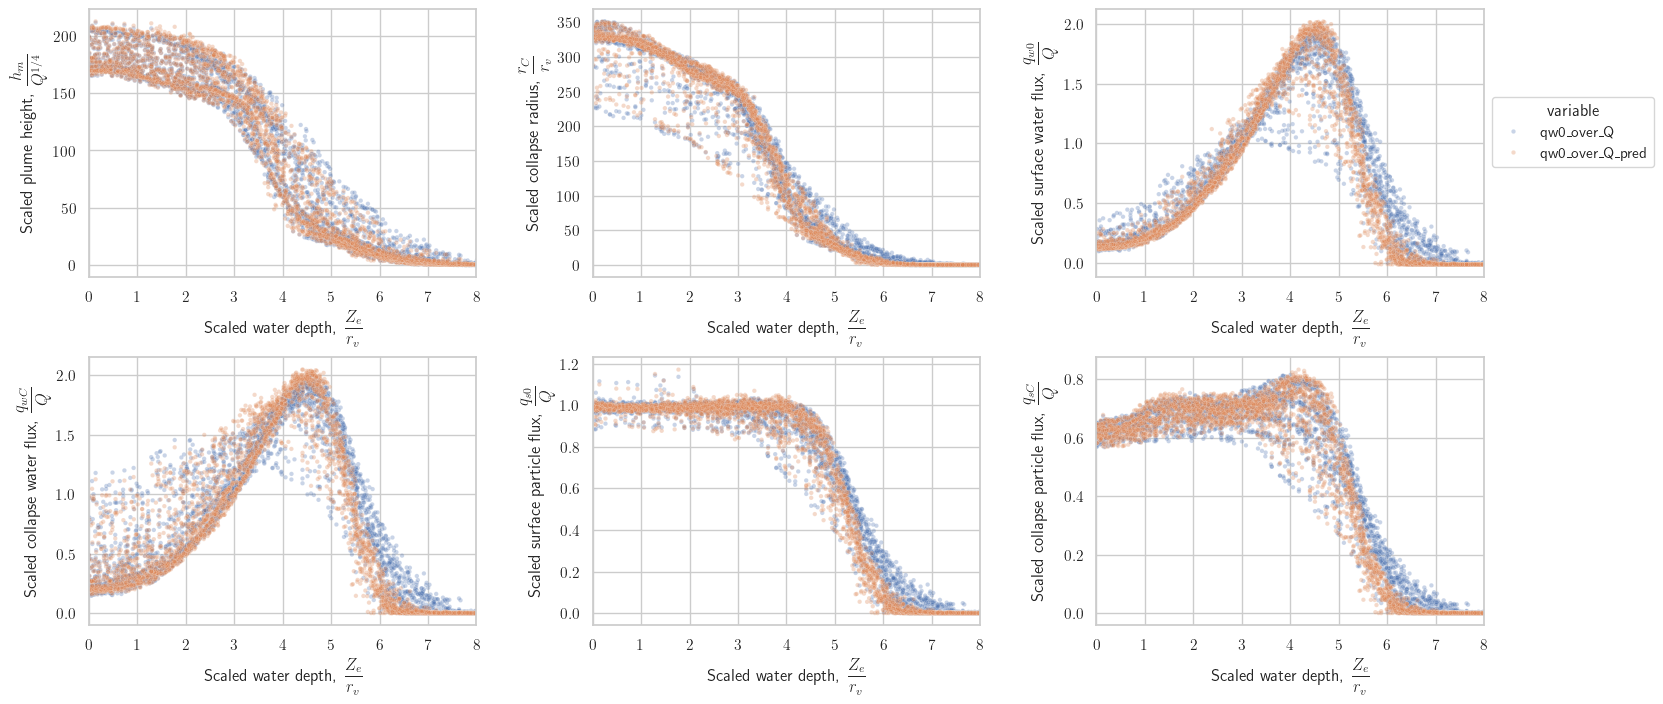

In [29]:
# Make a scaled data set to show test and validation data plotted over each

# Add in test data for comparison plots in seaborn, using the regular (unscaled) variable name
df_test_predict_scaled = df_predict_scaled.copy().rename(columns={col:col+'_pred' for col in scaled_output_vars})
df_test_predict_scaled = pd.concat([df_test_predict_scaled, averaged_scaled_test_data[scaled_output_vars]], axis=1)
# df_test_predict_scaled = df_test_predict_scaled.assign(hm=mc_df_test['hm'] / mc_df_test['Q']**(1/4))
# df_test_predict_scaled = df_test_predict_scaled.assign(rC=mc_df_test['rC'] / extrapVentRadius(mc_df_test['Q']))
# df_test_predict_scaled = df_test_predict_scaled.assign(**{col: mc_df_test[col] / mc_df_test['Q'] for col in output_vars[2::]})

# Plot the comparison
rft.double_var_panels_scatter(df_test_predict_scaled.sort_values('logQ',ascending=False),
                           x_var = 'Ze_over_Rv',
                           y_vars1 = scaled_output_vars,
                           y_vars2 = [var+'_pred' for var in scaled_output_vars],
                           # hue_var = '',
                          )


## Random forest output 2
Plot predictions against test output and report error

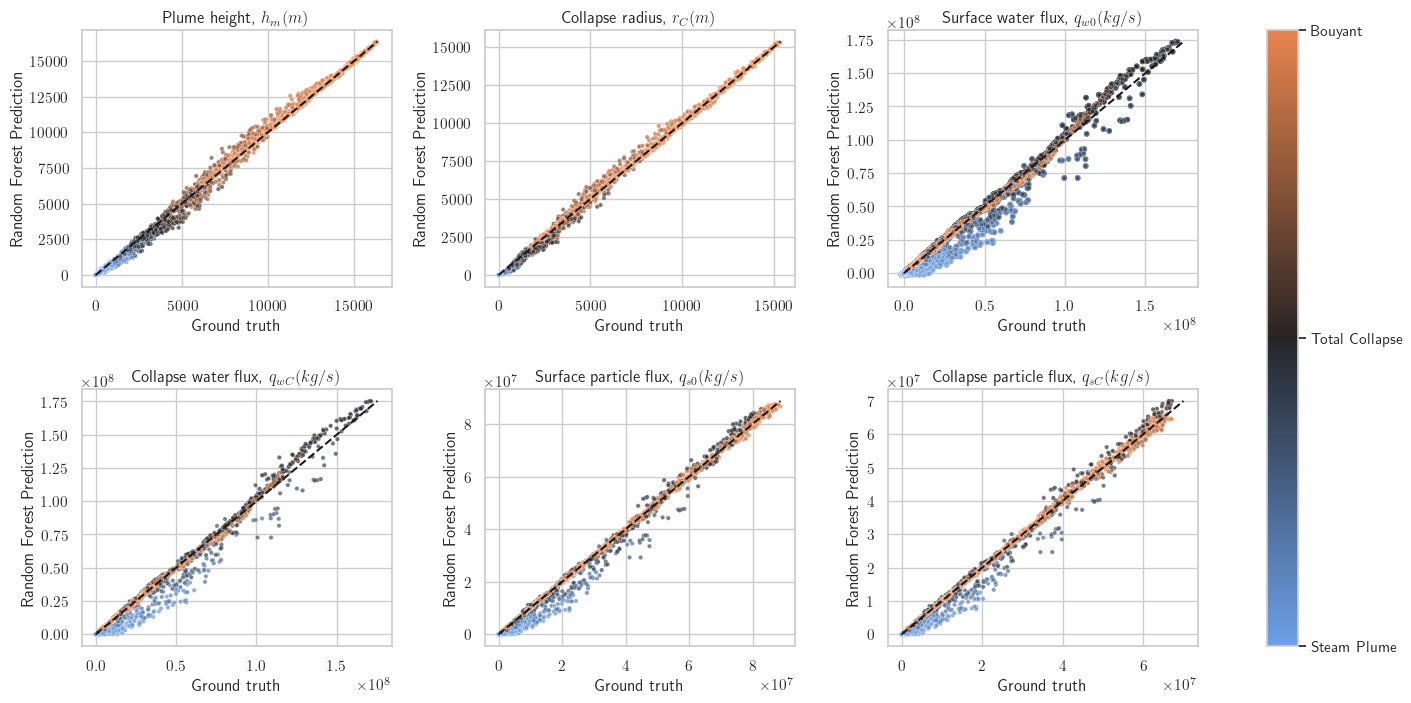

In [15]:
n_rows = 2
n_cols = ceil(len(scaled_output_vars)/n_rows)

fig,axes = plt.subplots(n_rows, n_cols, figsize=(18,8),gridspec_kw={'wspace':0.3, 'hspace':0.4})
cmap = sns.diverging_palette(30, 250, l=65, center="dark", as_cmap=True)

for ax,var in zip(axes.flatten(),output_vars):
    if ax==axes[0,n_cols-1]:
        show_legend = True
        sc=ax.scatter(df_test_predict[var], df_test_predict[var+'_pred'],
                    c = mc_df_test['clps_regime'],
                    s=10, cmap = cmap)
        cbar = fig.colorbar(sc,ax=axes,ticks=[0,1,2]) #,label=var_labels['clps_regime'],)
        cbar.ax.set_yticklabels(['Bouyant','Total Collapse','Steam Plume'])
        cbar.ax.invert_yaxis()
    else:
        show_legend = False  
        
    # Plot predictions against test set ground truth
    x_max = df_test_predict[[var, var+'_pred']].max(axis=None)
    ax.plot([0, x_max],[0, x_max],'--k')
    sns.scatterplot(data=df_test_predict, 
                x=var,y=var+'_pred',
                hue=mc_df_test['clps_regime'],
                # hue=df_test_predict_scaled['logQ'],
                s=10,
                # sizes=3,
                alpha=0.7,
                palette=cmap, #"crest", 
                # edgecolors=[0, 0, 0],
                ax=ax, 
                legend=False) #"ch:r=-.2,d=.3_r") #, edgecolors=[0, 0, 0])
    ax.set_title(rft.var_labels[var])
    ax.set_xlabel('Ground truth')
    ax.set_ylabel('Random Forest Prediction')
    
    # if show_legend:
        # plt.colorbar(mc_df_test['clps_regime'],axes=ax)
        # sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))



plt.show()

           hm        rC       qw0       qwC       qs0       qsC
idx                                                            
0    0.000198  0.000154  2.232744  2.223105  0.900817  1.100714
1    0.000145  0.000123  2.236449  2.222223  0.920652  1.053405
2    0.000144  0.000098  2.216044  2.208613  0.936739  0.756484
Ze_over_Rv     0.000000
hm_over_Q14    1.519387
logQ           0.000000
qs0_over_Q     0.017118
qsC_over_Q     0.013086
qw0_over_Q     0.042614
qwC_over_Q     0.041942
rC_over_Rv     2.640324
dtype: float64


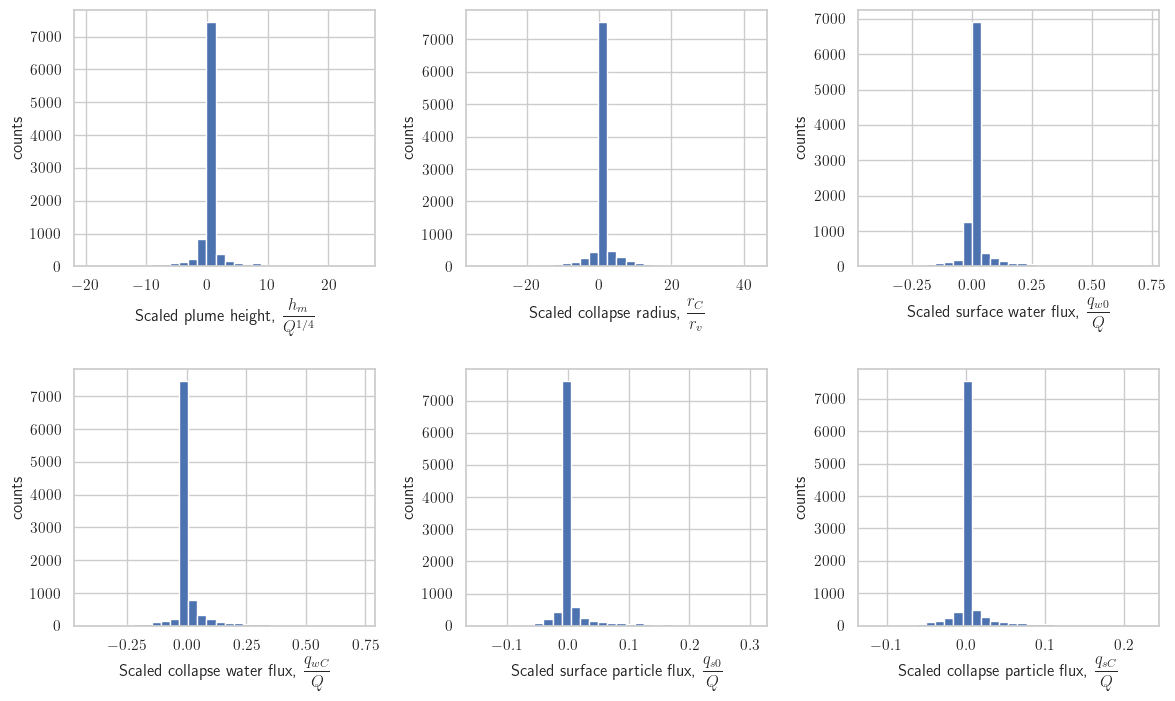

In [16]:
# pred_vars = [var+'_pred' for var in output_vars]
# y_pred = df_predict.rename(columns={pv: var for pv,var in zip(pred_vars,output_vars)})
# mse = mean_squared_error(df_test_predict[output_vars],df_test_predict[pred_vars])

# Get error estimate for averaged test set ground truth
rmse_test,nrmse_test,norm_error_test = rft.nrmse(mc_df_test[output_vars],averaged_test_data)

# Get error estimate for prediction set
rmse_raw,nrmse_raw,norm_error_raw = rft.nrmse(mc_df_test[output_vars],df_predict)

# Error between averaged and random forest sets -> ultimately the main interest
rmse,nrmse,norm_error = rft.nrmse(averaged_test_data,df_predict)

srmse,snrmse,snorm_error = rft.nrmse(averaged_scaled_test_data,df_predict_scaled)


all_rmse = pd.concat([nrmse_test, nrmse_raw, nrmse],axis=1).transpose()
all_rmse.assign(idx =['N_hood','RF','N_hood_RF'])
all_rmse.index.names = ['idx']

all_rmse = pd.concat([nrmse_test, nrmse_raw, nrmse],axis=1).transpose()
all_rmse.assign(idx =['Nhood','RF','Nhood_RF']) #,'Sc_Nhood_RF'])
all_rmse.index.names = ['idx']

print(all_rmse)
print(snrmse)


fig,axes = plt.subplots(2,3, figsize=(14,8),gridspec_kw={'wspace':0.3, 'hspace':0.4})
for ax,var in zip(axes.flatten(),scaled_output_vars):
    _ = ax.hist(snorm_error[var],bins=30,log=False)
    ax.set_xlabel(rft.var_labels[var])
    ax.set_ylabel('counts')
    # _ = axes[1].hist(norm_error_raw['hm'],bins=30,log=True)
    # _ = axes[2].hist(norm_error['hm'],bins=30,log=True)


In [17]:
df_test_predict[['hm','hm_pred','rC','rC_pred','qw0','qw0_pred']][0:10]

,hm,hm_pred,rC,rC_pred,qw0,qw0_pred
0,0.000000,0.274919,0.000000,0.000000,-4.373586e+05,-4.232591e+05
1,12809.663046,13042.096049,9620.487867,9817.104958,4.936302e+07,4.881009e+07
2,15.803822,26.188453,0.000000,0.000000,-7.330693e+05,-7.177376e+05
3,11150.434496,11090.394980,7539.677763,7505.898477,3.003771e+07,3.143504e+07
4,126.967691,116.009351,1.365610,0.091233,-1.296939e+05,-1.733351e+05
5,11165.725584,11163.183693,7263.131785,7269.729718,5.112049e+06,4.912183e+06
6,0.000000,0.225256,0.000000,0.000000,-9.309172e+05,-8.695348e+05
7,0.000000,0.000000,0.000000,0.000000,-1.472937e+05,-1.582456e+05
8,0.000000,0.000000,0.000000,0.000000,-2.321959e+04,-2.394332e+04
9,0.000000,0.000075,0.000000,0.000000,-3.520674e+05,-3.164473e+05


## Run a couple tests with fixed mass flux Q, and varying water depth Ze, simulating the real use case
Run test query points along fixed Q, varying Ze from min to max. This is similar to how the random forest model will be queried with the glaciovolcano model

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished


array([[0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.]])

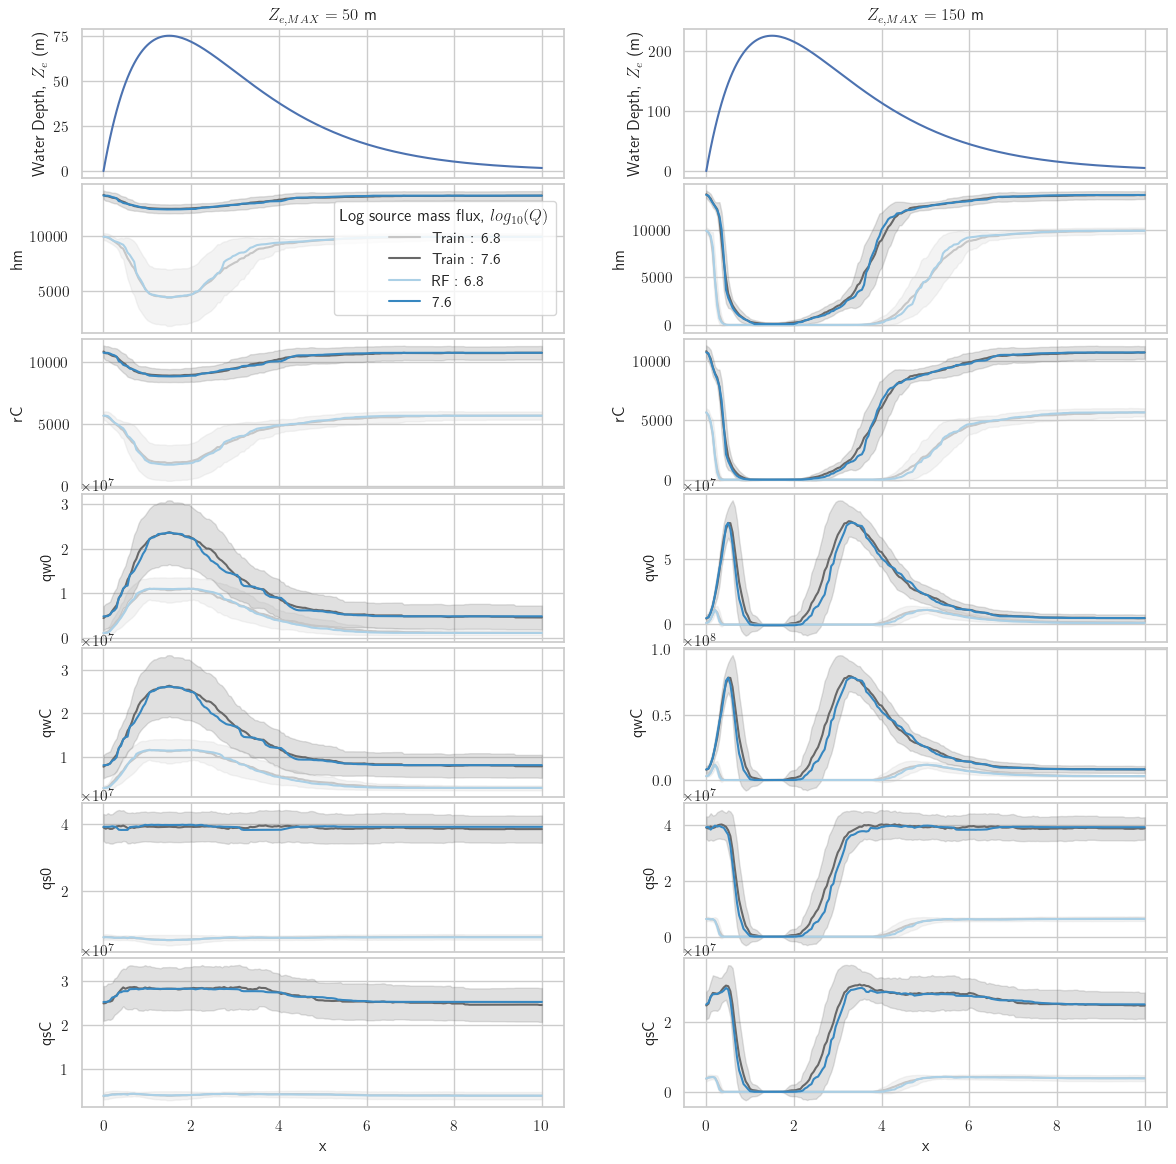

In [18]:
# Simulation parameters testing a hypothetical usage case for the random forest predictons
Q_vector = [6e6, 4e7] # Q, kg/s - Span about an order of magnitude in mass flux for testing
Ze_max = [50, 150] #, 180] # sample MAX water depth occurring in each simulation
# search_radius = 0.07

rft.simulate_model_scenario(regressor_rf, mc_df_test[input_vars + output_vars],
                            Q = np.round(np.log10(Q_vector),decimals=1),
                            Ze_max = Ze_max,
                            coord_ranges = {'Ze': Ze_range, 'logQ': Q_range},
                            search_radius = search_radius
                           )
        